## Import Packages

In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import gc

DATA_PATH = "./ashrae-energy-prediction/"

## Utility Functions

In [88]:
# Original code from https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling by @aitude

def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def features_engineering(df):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    df['square_feet'] =  np.log1p(df['square_feet'])
    
    # Remove Unused Columns
    # drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count"]
    drop = ["timestamp"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    #le = LabelEncoder()
    #df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

## Load Data

In [295]:
train_df = pd.read_csv(DATA_PATH + 'train.csv')

# Remove outliers
train_df = train_df [ train_df['building_id'] != 1099 ]
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

building_df = pd.read_csv(DATA_PATH + 'building_metadata.csv')
weather_df = pd.read_csv(DATA_PATH + 'weather_train.csv')

## Load Test Data

In [296]:
test_df = pd.read_csv(DATA_PATH + 'test.csv')
row_ids = test_df["row_id"]
test_df.drop("row_id", axis=1, inplace=True)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 954.38 MB
Memory usage after optimization is: 199.59 MB
Decreased by 79.1%


## Fill Weather-train Information

I'm using [this kernel](https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling) to handle missing weather information.

In [297]:
weather_df = fill_weather_dataset(weather_df)

In [298]:
building_df['age'] = building_df['year_built'].max() - building_df['year_built'] + 1

In [299]:
weather_df = weather_df.drop(['sea_level_pressure', 'wind_direction', 'wind_speed'], axis=1)

In [300]:
building_df = building_df.drop(['year_built', 'floor_count'], axis=1)

## Memory Reduction

In [301]:
train_df = reduce_mem_usage(train_df,use_float16=True)
building_df = reduce_mem_usage(building_df,use_float16=True)
weather_df = reduce_mem_usage(weather_df,use_float16=True)

Memory usage of dataframe is 757.31 MB
Memory usage after optimization is: 322.24 MB
Decreased by 57.4%
Memory usage of dataframe is 0.06 MB
Memory usage after optimization is: 0.01 MB
Decreased by 73.5%
Memory usage of dataframe is 6.43 MB
Memory usage after optimization is: 1.85 MB
Decreased by 71.2%


## Merge building, weather Data to train

We need to add building and weather information into training dataset.

In [302]:
train_df = train_df.merge(building_df, left_on='building_id',right_on='building_id',how='left')
train_df = train_df.merge(weather_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
del weather_df
gc.collect()

0

## Merge Building Data to test

In [303]:
test_df = test_df.merge(building_df,left_on='building_id',right_on='building_id',how='left')
del building_df
gc.collect()

20

## Fill Weather-test Information

In [304]:
weather_df = pd.read_csv(DATA_PATH + 'weather_test.csv')
weather_df = fill_weather_dataset(weather_df)
weather_df = weather_df.drop(['sea_level_pressure', 'wind_direction', 'wind_speed'], axis=1)
weather_df = reduce_mem_usage(weather_df)

Memory usage of dataframe is 12.83 MB
Memory usage after optimization is: 5.84 MB
Decreased by 54.5%


## Merge Weather-test Data

In [305]:
test_df = test_df.merge(weather_df,how='left',on=['timestamp','site_id'])
del weather_df
gc.collect()

20

## Features Engineering

In [306]:
train_df = features_engineering(train_df)

In [307]:
train_df['log_meter_reading'] = np.log1p(train_df["meter_reading"])

In [308]:
test_df = features_engineering(test_df)

## Target Encoding

In [283]:
n_folds = 10
kf = TimeSeriesSplit(n_splits=n_folds)

In [319]:
i_cols = ['site_id', 'primary_use', 'weekend']
for df in [train_df, test_df]:
    for col in i_cols:
        df['meter_' + col] = df['meter'].astype(str) + '_' + df[col].astype(str)

In [323]:
target_mean = train_df['log_meter_reading'].mean()
i_cols = ['meter_site_id', 'meter_primary_use', 'meter_weekend']
# 1...primary_use
# 2...building_id, primary_use
# 3...primary_use, weekend, 元除去
# 4...meter_site_id, meter_primary_use, meter_weekend
# meterとsite_id, primary_use, weekendを組み合わせる→target_encoding→元の列は消す

# 7...全てのtarget_encを平均、各個の値は除去
 # ['target_enc_mean'] = ...
    # t = t.drop([''...], axis=0)
# i_cols = ['building_id', 'meter', 'site_id', 'primary_use', 'weekend']
for col in i_cols:
    train_df[col + '_target_enc'] = target_mean
    
    for i, (previous_index, current_index) in enumerate(kf.split(train_df)):
        
        if i == 0:
            continue
            
        else:
            train_previous = train_df.iloc[previous_index]
            # 列番号
            col_num = train_df.columns.get_loc(col + '_target_enc')
            
            temp_dict = train_previous.groupby([col])['log_meter_reading'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_enc'})
            temp_dict.index = temp_dict[col].values
            temp_dict = temp_dict[col + '_target_enc'].to_dict()
            
            train_df.iloc[current_index, col_num] = train_df.iloc[current_index][col].map(temp_dict)
    
    temp_dict = train_df.groupby([col])['log_meter_reading'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_enc'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_enc'].to_dict()
    test_df[col + '_target_enc'] = test_df[col].map(temp_dict)
    
    # 元の列除去
    train_df = train_df.drop(col, axis=1)
    test_df = test_df.drop(col, axis=1)

In [324]:
train_df.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,age,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,weekend,log_meter_reading,meter_site_id_target_enc,meter_primary_use_target_enc,meter_weekend_target_enc
0,105,0,23.303600,1,0,10.832181,NaN,3.800781,0.0,2.400391,0.0,0,4,3.190624,4.275923,4.275923,4.275923
1,106,0,0.374600,1,0,8.589514,NaN,3.800781,0.0,2.400391,0.0,0,4,0.318163,4.275923,4.275923,4.275923
2,106,3,0.000000,1,0,8.589514,NaN,3.800781,0.0,2.400391,0.0,0,4,0.000000,4.275923,4.275923,4.275923
3,107,0,175.184006,1,0,11.487946,13.0,3.800781,0.0,2.400391,0.0,0,4,5.171529,4.275923,4.275923,4.275923
4,108,0,91.265297,1,0,11.309352,105.0,3.800781,0.0,2.400391,0.0,0,4,4.524668,4.275923,4.275923,4.275923


In [325]:
test_df.head()

,building_id,meter,site_id,primary_use,square_feet,age,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,weekend,meter_site_id_target_enc,meter_primary_use_target_enc,meter_weekend_target_enc
0,0,0,0,0,8.913685,10.0,17.799999,4.0,11.7,0.282609,0,6,5.238374,4.421944,3.970106
1,1,0,0,0,7.908755,14.0,17.799999,4.0,11.7,0.282609,0,6,5.238374,4.421944,3.970106
2,2,0,0,0,8.589886,27.0,17.799999,4.0,11.7,0.282609,0,6,5.238374,4.421944,3.970106
3,3,0,0,0,10.072639,16.0,17.799999,4.0,11.7,0.282609,0,6,5.238374,4.421944,3.970106
4,4,0,0,0,11.666573,43.0,17.799999,4.0,11.7,0.282609,0,6,5.238374,4.421944,3.970106


## Features & Target Variables

In [326]:
#target = np.log1p(train_df["meter_reading"])
target = train_df['log_meter_reading']
X = train_df.drop(['meter_reading', 'log_meter_reading'], axis = 1)
del train_df
gc.collect()

2994

##  KFOLD LIGHTGBM Model

### 40 min

In [327]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]
#categorical_features = ['building_id', 'site_id', 'meter']
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 128,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

kf = KFold(n_splits=5, random_state=123)
models = []
y_pred = np.zeros(X.shape[0])
for i, (train_index, valid_index) in enumerate(kf.split(X)):
    print(f'Fold {i + 1} training...')
    score = 0
    
    X_train = X.loc[train_index]
    y_train = target.loc[train_index]
    X_valid = X.loc[valid_index]
    y_valid = target.loc[valid_index]
    
    d_training = lgb.Dataset(X_train, label=y_train,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(X_valid, label=y_valid,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=2000, valid_sets=[d_training,d_test], verbose_eval=100, early_stopping_rounds=50)
    models.append(model)
    
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    y_pred[valid_index] = y_pred_valid
    
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    score += rmse / 5
    
    del X_train, y_train, X_valid, y_valid, d_training, d_test
    gc.collect()
print(f'CV RMSE: {score}')
print(f'RMSE: {np.sqrt(mean_squared_error(target, y_pred))}')

Fold 1 training...
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.894069	valid_1's rmse: 1.60675
[200]	training's rmse: 0.815974	valid_1's rmse: 1.55366
[300]	training's rmse: 0.780396	valid_1's rmse: 1.54565
[400]	training's rmse: 0.757547	valid_1's rmse: 1.54299
[500]	training's rmse: 0.741494	valid_1's rmse: 1.54033
[600]	training's rmse: 0.728879	valid_1's rmse: 1.53828
[700]	training's rmse: 0.718247	valid_1's rmse: 1.536
[800]	training's rmse: 0.709381	valid_1's rmse: 1.53487
[900]	training's rmse: 0.702393	valid_1's rmse: 1.53404
[1000]	training's rmse: 0.696077	valid_1's rmse: 1.53363
[1100]	training's rmse: 0.689983	valid_1's rmse: 1.53279
[1200]	training's rmse: 0.684044	valid_1's rmse: 1.5323
[1300]	training's rmse: 0.678839	valid_1's rmse: 1.5312
[1400]	training's rmse: 0.674159	valid_1's rmse: 1.53042
Early stopping, best iteration is:
[1404]	training's rmse: 0.673869	valid_1's rmse: 1.53031
Fold 2 training...
Training until validatio

In [288]:
#categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]
categorical_features = ['building_id', 'site_id', 'meter']
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 128,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

kf = KFold(n_splits=5, random_state=35)
models = []
y_pred = np.zeros(X.shape[0])
for i, (train_index, valid_index) in enumerate(kf.split(X)):
    print(f'Fold {i + 1} training...')
    score = 0
    
    X_train = X.loc[train_index]
    y_train = target.loc[train_index]
    X_valid = X.loc[valid_index]
    y_valid = target.loc[valid_index]
    
    d_training = lgb.Dataset(X_train, label=y_train,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(X_valid, label=y_valid,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=2000, valid_sets=[d_training,d_test], verbose_eval=100, early_stopping_rounds=50)
    models.append(model)
    
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    y_pred[valid_index] = y_pred_valid
    
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    score += rmse / 5
    
    del X_train, y_train, X_valid, y_valid, d_training, d_test
    gc.collect()
print(f'CV RMSE: {score}')
print(f'RMSE: {np.sqrt(mean_squared_error(target, y_pred))}')

Fold 1 training...
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.908248	valid_1's rmse: 1.08427
[200]	training's rmse: 0.806691	valid_1's rmse: 1.06048
Early stopping, best iteration is:
[236]	training's rmse: 0.793428	valid_1's rmse: 1.05918
Fold 2 training...
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.900845	valid_1's rmse: 0.991259
[200]	training's rmse: 0.810171	valid_1's rmse: 0.949068
[300]	training's rmse: 0.774685	valid_1's rmse: 0.933096
[400]	training's rmse: 0.754876	valid_1's rmse: 0.922781
[500]	training's rmse: 0.738819	valid_1's rmse: 0.917364
[600]	training's rmse: 0.725466	valid_1's rmse: 0.910976
[700]	training's rmse: 0.715262	valid_1's rmse: 0.907585
[800]	training's rmse: 0.705717	valid_1's rmse: 0.905558
[900]	training's rmse: 0.696843	valid_1's rmse: 0.903816
[1000]	training's rmse: 0.689107	valid_1's rmse: 0.901944
[1100]	training's rmse: 0.681783	valid_1's rmse: 0.90034
[1200]	tr

In [214]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 128,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

kf = KFold(n_splits=5, random_state=42)
models = []
y_pred = np.zeros(X.shape[0])
for i, (train_index, valid_index) in enumerate(kf.split(X)):
    print(f'Fold {i + 1} training...')
    score = 0
    
    X_train = X.loc[train_index]
    y_train = target.loc[train_index]
    X_valid = X.loc[valid_index]
    y_valid = target.loc[valid_index]
    
    d_training = lgb.Dataset(X_train, label=y_train,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(X_valid, label=y_valid,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=2000, valid_sets=[d_training,d_test], verbose_eval=100, early_stopping_rounds=50)
    models.append(model)
    
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    y_pred[valid_index] = y_pred_valid
    
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    score += rmse / 5
    
    del X_train, y_train, X_valid, y_valid, d_training, d_test
    gc.collect()
print(f'CV RMSE: {score}')
print(f'RMSE: {np.sqrt(mean_squared_error(target, y_pred))}')

Fold 1 training...
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.928292	valid_1's rmse: 1.06303
[200]	training's rmse: 0.836491	valid_1's rmse: 0.998188
[300]	training's rmse: 0.803689	valid_1's rmse: 0.984973
[400]	training's rmse: 0.785367	valid_1's rmse: 0.979291
[500]	training's rmse: 0.769536	valid_1's rmse: 0.973289
[600]	training's rmse: 0.754739	valid_1's rmse: 0.968982
[700]	training's rmse: 0.743057	valid_1's rmse: 0.968563
Early stopping, best iteration is:
[669]	training's rmse: 0.746264	valid_1's rmse: 0.968272
Fold 2 training...
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.922809	valid_1's rmse: 0.990148
[200]	training's rmse: 0.831335	valid_1's rmse: 0.94825
[300]	training's rmse: 0.796159	valid_1's rmse: 0.936173
[400]	training's rmse: 0.775796	valid_1's rmse: 0.929366
[500]	training's rmse: 0.758444	valid_1's rmse: 0.92687
[600]	training's rmse: 0.74273	valid_1's rmse: 0.924646
[700]	train

In [176]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 128,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

kf = KFold(n_splits=5, random_state=42)
models = []
y_pred = np.zeros(X.shape[0])
for i, (train_index, valid_index) in enumerate(kf.split(X)):
    print(f'Fold {i + 1} training...')
    score = 0
    
    X_train = X.loc[train_index]
    y_train = target.loc[train_index]
    X_valid = X.loc[valid_index]
    y_valid = target.loc[valid_index]
    
    d_training = lgb.Dataset(X_train, label=y_train,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(X_valid, label=y_valid,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=2000, valid_sets=[d_training,d_test], verbose_eval=100, early_stopping_rounds=50)
    models.append(model)
    
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    y_pred[valid_index] = y_pred_valid
    
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    score += rmse / 5
    
    del X_train, y_train, X_valid, y_valid, d_training, d_test
    gc.collect()
print(f'CV RMSE: {score}')
print(f'RMSE: {np.sqrt(mean_squared_error(target, y_pred))}')

Fold 1 training...
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.944062	valid_1's rmse: 1.08708
[200]	training's rmse: 0.880738	valid_1's rmse: 1.05544
[300]	training's rmse: 0.857731	valid_1's rmse: 1.05323
Early stopping, best iteration is:
[276]	training's rmse: 0.861726	valid_1's rmse: 1.05245
Fold 2 training...
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.94588	valid_1's rmse: 1.01373
[200]	training's rmse: 0.878458	valid_1's rmse: 0.993536
[300]	training's rmse: 0.854656	valid_1's rmse: 0.991762
Early stopping, best iteration is:
[326]	training's rmse: 0.851539	valid_1's rmse: 0.991399
Fold 3 training...
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.943418	valid_1's rmse: 1.03213
[200]	training's rmse: 0.888862	valid_1's rmse: 0.990122
[300]	training's rmse: 0.869386	valid_1's rmse: 0.98252
[400]	training's rmse: 0.856909	valid_1's rmse: 0.979151
[500]	training

In [44]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

kf = TimeSeriesSplit(n_splits=5)
#models = []
y_pred = np.zeros(X.shape[0])
for i, (train_index, valid_index) in enumerate(kf.split(X)):
    print(f'Fold {i + 1} training...')
    score = 0
    
    X_train = X.loc[train_index]
    y_train = target.loc[train_index]
    X_valid = X.loc[valid_index]
    y_valid = target.loc[valid_index]
    
    d_training = lgb.Dataset(X_train, label=y_train,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(X_valid, label=y_valid,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=100, early_stopping_rounds=50)
    #models.append(model)
    
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    y_pred[valid_index] = y_pred_valid
    
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    score += rmse / 5
    
    del X_train, y_train, X_valid, y_valid, d_training, d_test
    gc.collect()

print(f'CV RMSE: {score}')
print(f'RMSE: {np.sqrt(mean_squared_error(target, y_pred))}')

Fold 1 training...
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.540025	valid_1's rmse: 1.04524
[200]	training's rmse: 0.467257	valid_1's rmse: 1.04482
Early stopping, best iteration is:
[150]	training's rmse: 0.492052	valid_1's rmse: 1.04375
Fold 2 training...
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.649371	valid_1's rmse: 1.22881
[200]	training's rmse: 0.586207	valid_1's rmse: 1.22241
Early stopping, best iteration is:
[204]	training's rmse: 0.584898	valid_1's rmse: 1.22202
Fold 3 training...
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.708142	valid_1's rmse: 1.01139
Early stopping, best iteration is:
[70]	training's rmse: 0.757881	valid_1's rmse: 0.999231
Fold 4 training...
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.737518	valid_1's rmse: 1.19278
Early stopping, best iteration is:
[76]	training's rmse: 0.772253	valid

In [328]:
del X, target
gc.collect()

20

## Important Features

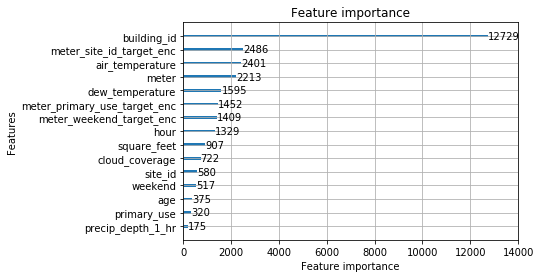

In [329]:
lgb.plot_importance(model)
plt.show()

## Prediction 1時間以上

In [330]:
results = []
"""
model_all = lgb.LGBMRegressor(**params, num_boost_round=int(np.floor(model.best_iteration * 1.25)))
model_all.fit(X, target)
results = np.expm1(model_all.predict(test_df))
"""

for model in tqdm(models):
    if  results == []:
        results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()


100%|██████████| 5/5 [58:51<00:00, 706.34s/it]   


In [331]:
del test_df
gc.collect()

20

## Submission

In [332]:
today = str(datetime.date.today())
results_df = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(results, 0, a_max=None)})
del row_ids,results
gc.collect()
results_df.to_csv(f"submission_{today}_TargetEnc_4.csv", index=False)

In [333]:
results_df.head(20)

,row_id,meter_reading
0,0,199.251543
1,1,88.056832
2,2,7.122924
3,3,325.375114
4,4,939.313006
5,5,11.834825
6,6,111.962977
7,7,426.439150
8,8,630.100929
9,9,436.320014


<font color="green">**Give me your feedback and if you find my kernel is clean and helpful, please UPVOTE**</font>